# Dealias CSAPR2

## Imports

In [28]:
import pyart
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmweather

0.3.0


In [12]:
files = sorted(glob.glob("/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.23*"))
files

['/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.230006.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.230950.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.231008.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.231952.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.232010.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.232954.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.233012.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.233956.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.234015.nc',
 '/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.234958.nc',


In [13]:
radar = pyart.io.read(files[-5])

In [17]:
vel_field = "mean_doppler_velocity"
ref_field = "reflectivity"

In [22]:
ref = radar.fields['reflectivity']['data']
vel = radar.fields['mean_doppler_velocity']['data']
rhv = radar.fields['copol_correlation_coeff']['data']
spw = radar.fields['spectral_width']['data']

# mask noise in velocity using spectrum_width
is_messy = ref < -30.0
vel = np.ma.masked_where(is_messy, vel)

is_messy = ref > 100.0
vel = np.ma.masked_where(is_messy, vel)

is_messy = spw > 8
vel = np.ma.masked_where(is_messy, vel)

field_dict = {'data' : vel}
for key in ['long_name', 'units', #'valid_min', 'valid_max',
            'standard_name', 'coordinates']:
    field_dict.update({key : radar.fields[vel_field][key]})
radar.add_field('masked_velocity', field_dict, replace_existing=True)

# mask noise in reflectivity  using spectrum_width
is_messy = ref > 100.0
ref = np.ma.masked_where(is_messy, ref)
is_messy = ref < -30.0
ref = np.ma.masked_where(is_messy, ref)
is_messy = spw > 8
ref = np.ma.masked_where(is_messy, ref)
field_dict = {'data' : ref}

for key in ['long_name', 'units', #'valid_min', 'valid_max',
            'standard_name', 'coordinates']:
    field_dict.update({key : radar.fields[ref_field][key]})
radar.add_field('masked_reflectivity', field_dict, replace_existing=True)
#Filtering
gf = pyart.correct.GateFilter(radar)
gf.exclude_masked('masked_velocity')
#Dealias
dealias_vel = pyart.correct.dealias_region_based(
        radar, interval_splits=4, interval_limits=None, vel_field='masked_velocity',
        keep_original=False, nyquist_vel=None, check_nyquist_uniform=True,
        rays_wrap_around=True, set_limits=False)
radar.add_field('corrected_velocity', dealias_vel)


#Noise Filtering reflectivity and velocity using RHOhv
ref = radar.fields['masked_reflectivity']['data']
vel = radar.fields['corrected_velocity']['data']
is_messy = rhv < 0.4
vel = np.ma.masked_where(is_messy, vel)

# mask noise in spectrum width
is_messy = spw > 8
vel = np.ma.masked_where(is_messy, vel)

# mask noise in reflectivity
is_messy = rhv < 0.4
ref = np.ma.masked_where(is_messy, ref)
is_messy = spw > 8
ref = np.ma.masked_where(is_messy, ref)

radar.fields['corrected_velocity']['data']=vel
radar.fields['masked_reflectivity']['data']=ref

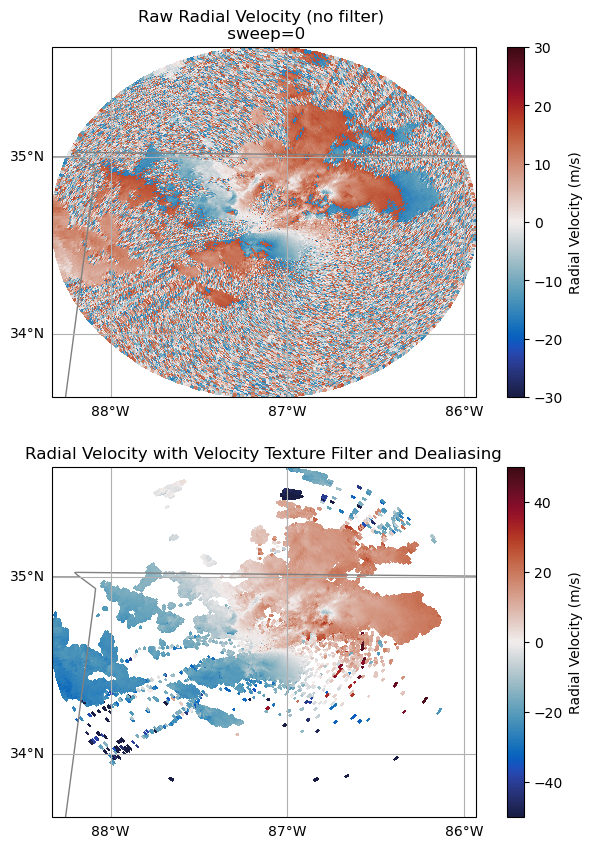

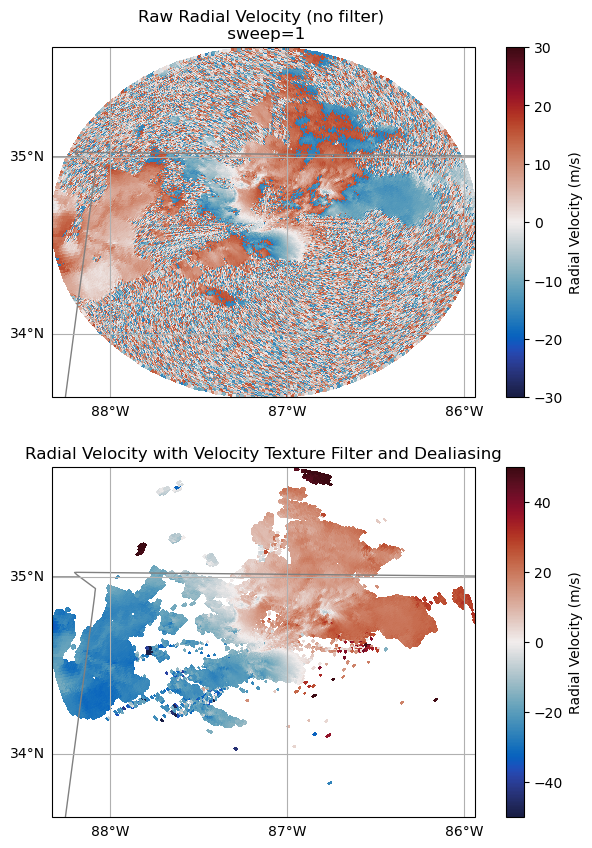

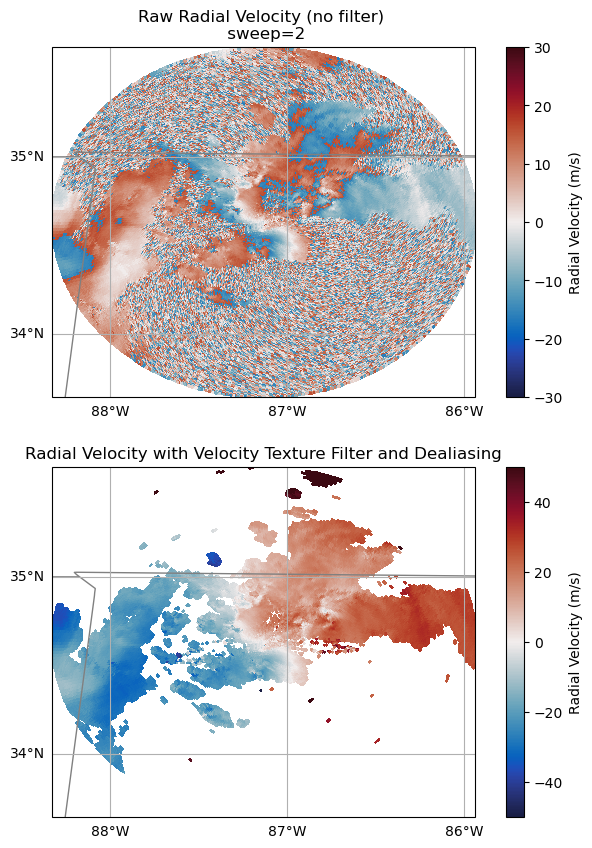

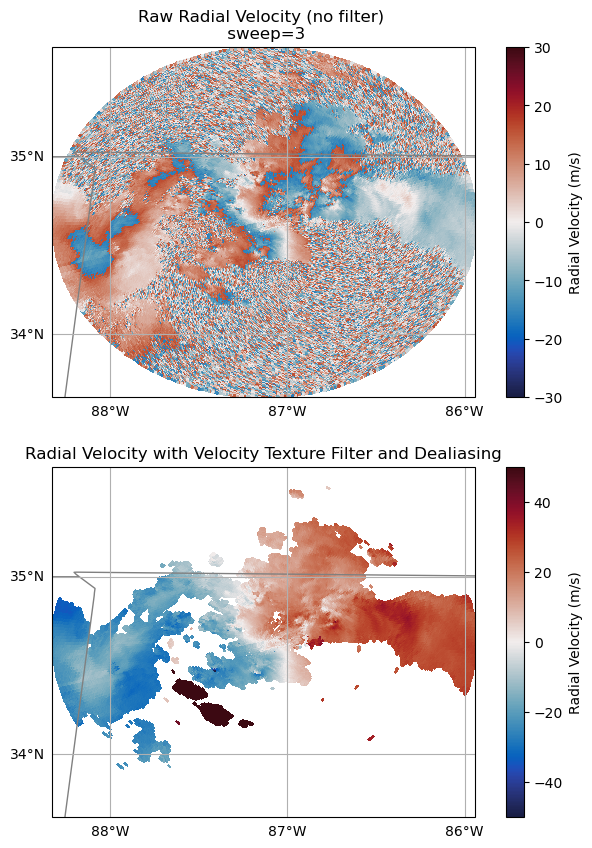

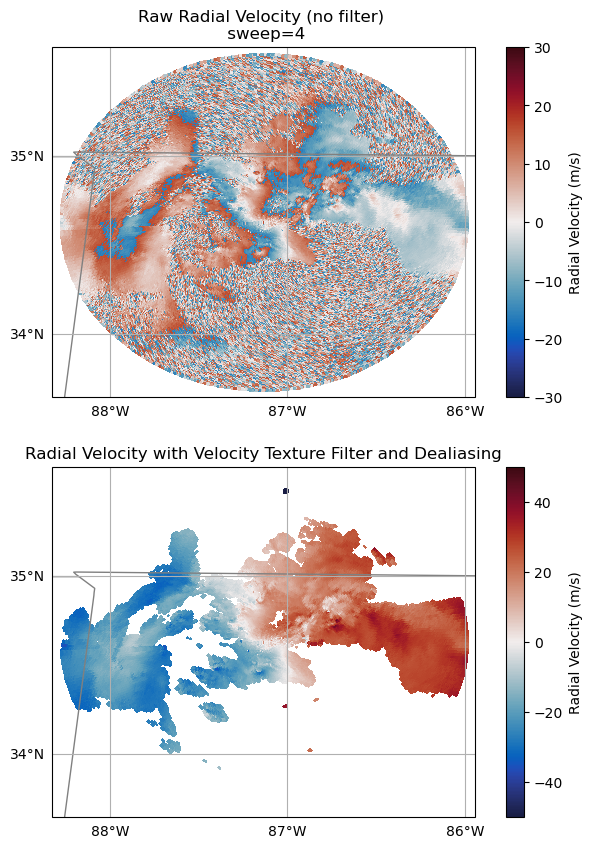

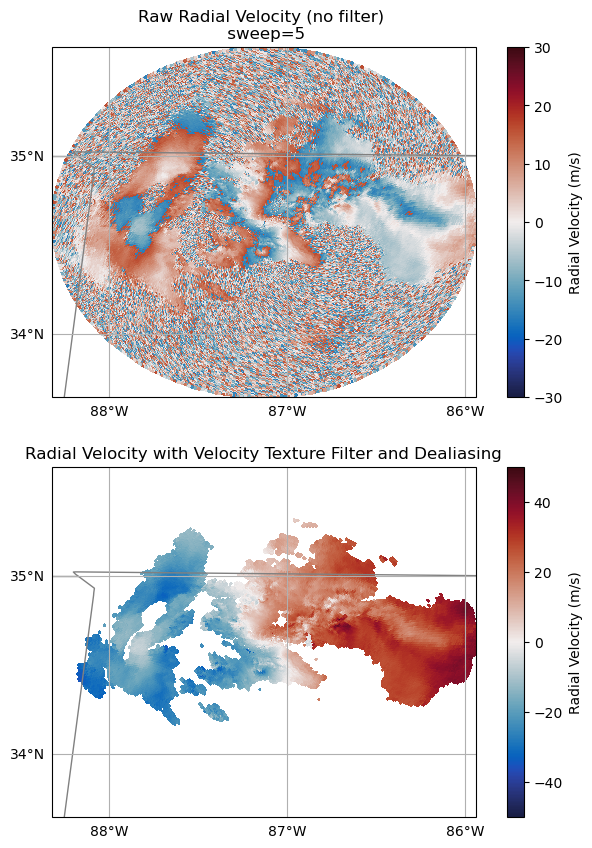

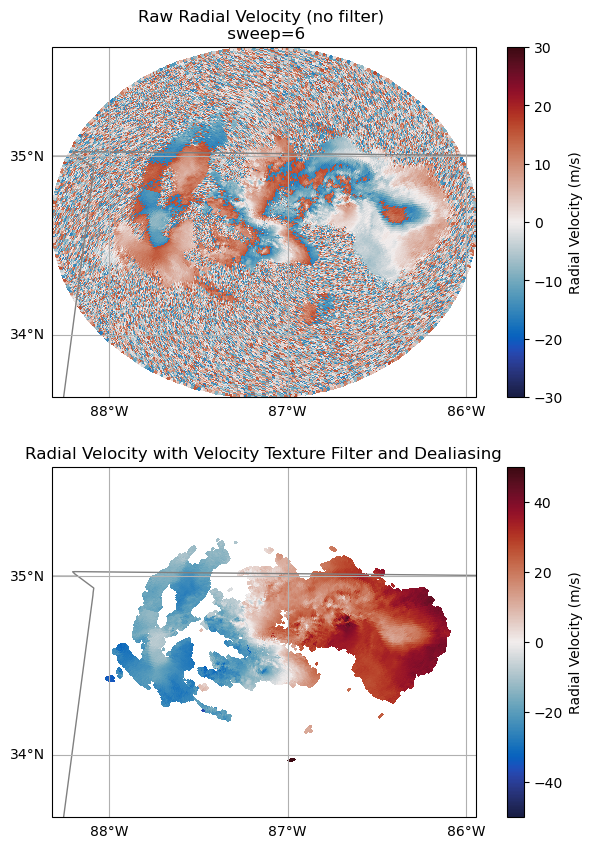

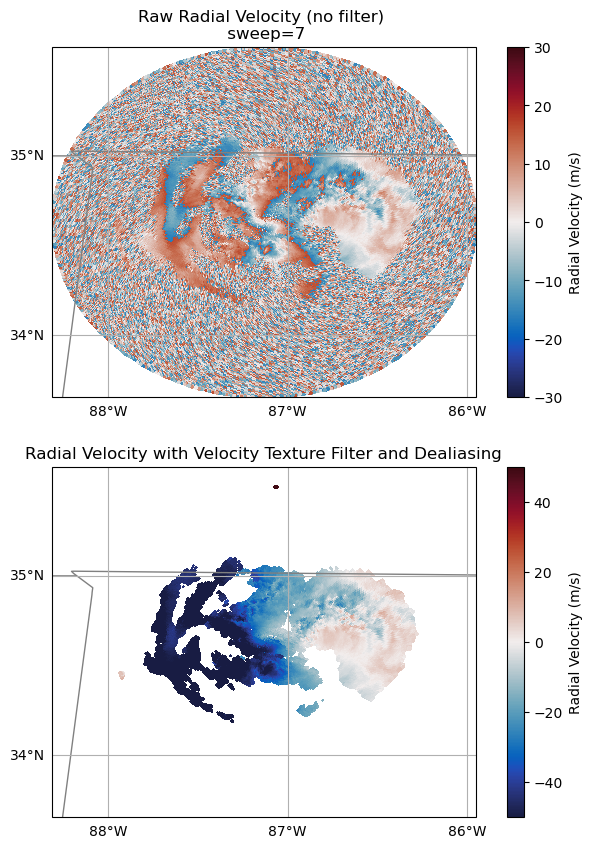

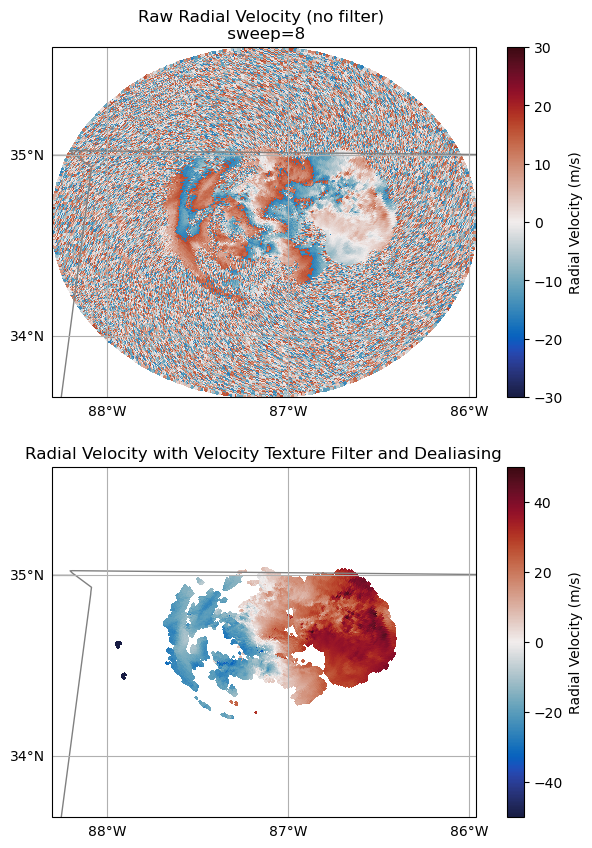

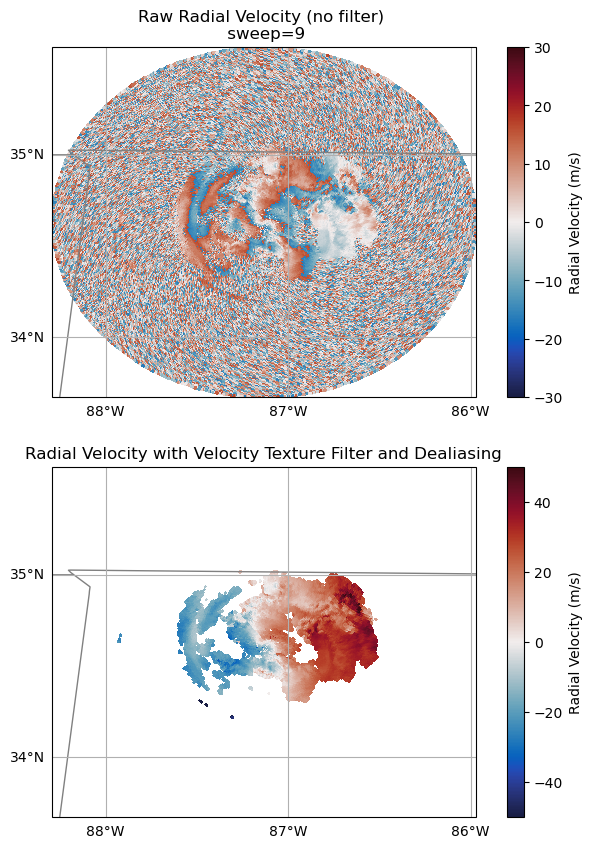

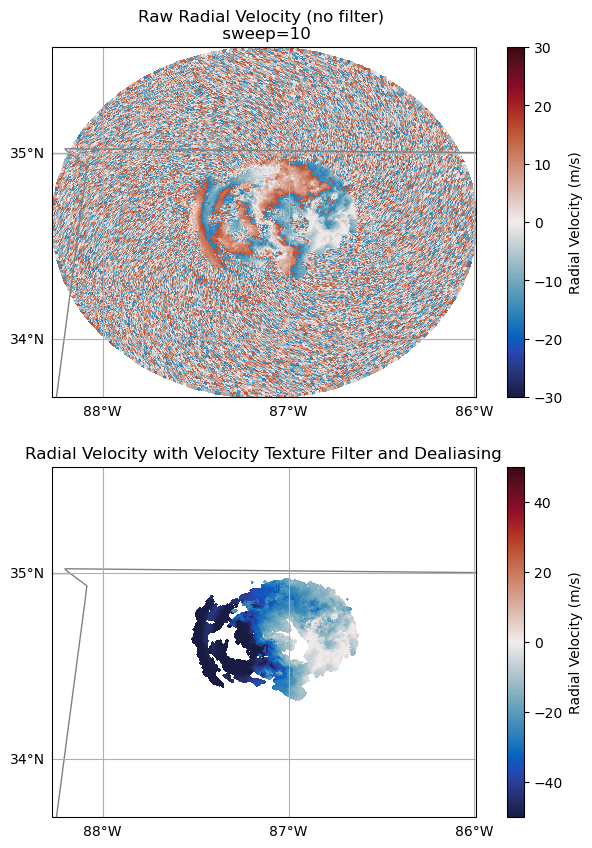

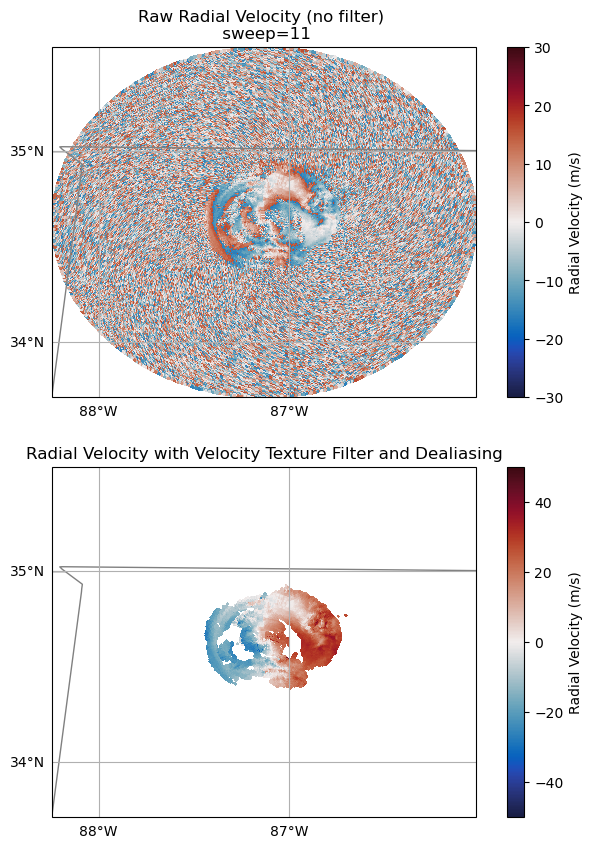

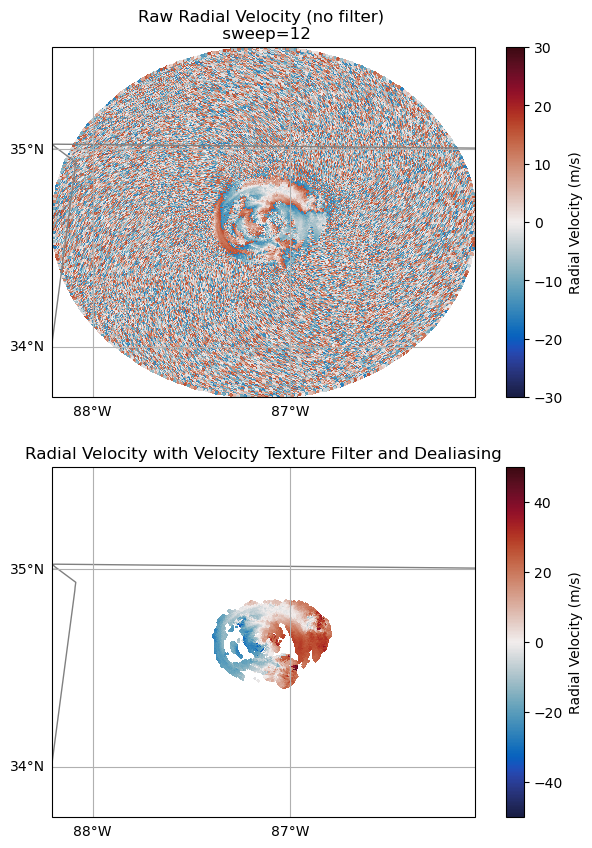

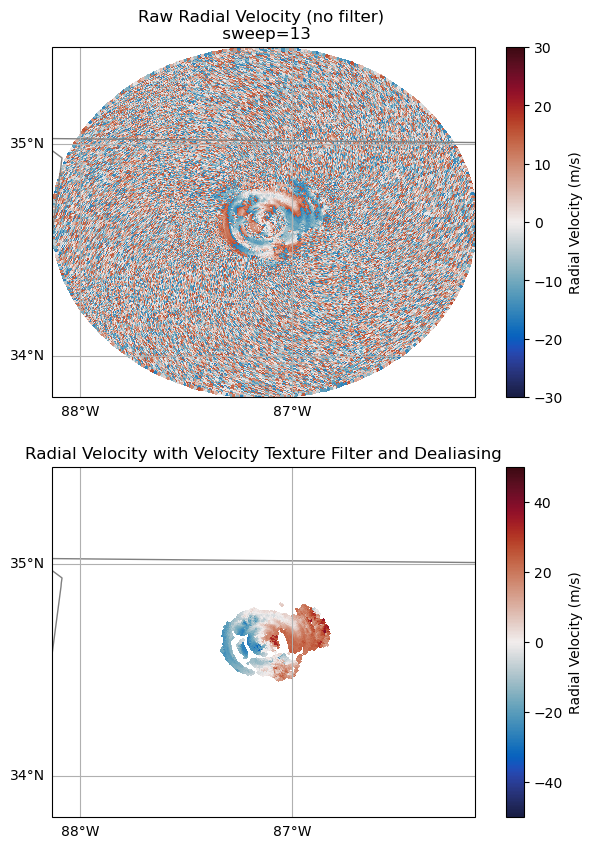

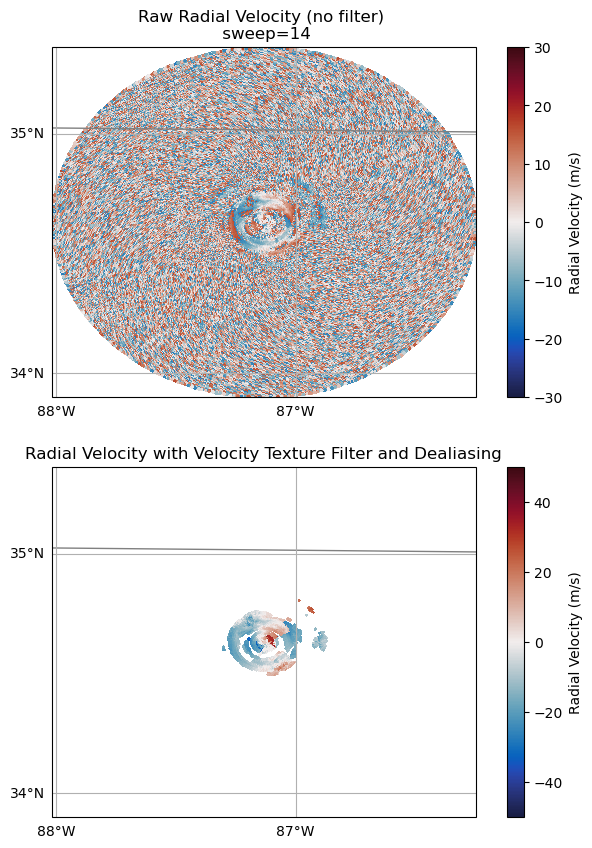

In [37]:
for sweep in range(0, radar.nsweeps):
    # Plot our Unfiltered Data
    fig = plt.figure(figsize=[8, 10])
    ax = plt.subplot(211, projection=ccrs.PlateCarree())
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('mean_doppler_velocity',
                         title=f'Raw Radial Velocity (no filter) \n sweep={sweep}',
                         ax=ax,
                         sweep=sweep,
                         resolution='50m',
                         vmin=-30,
                         vmax=30,
                         projection=ccrs.PlateCarree(),
                         colorbar_label='Radial Velocity (m/s)',
                         cmap='balance')
    
    ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())
    
    # Plot our filtered, dealiased data
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('corrected_velocity',
                         title='Radial Velocity with Velocity Texture Filter and Dealiasing',
                         ax=ax2,
                         sweep=sweep,
                         resolution='50m',
                         vmin=-50,
                         vmax=50, 
                         projection=ccrs.PlateCarree(),
                         gatefilter=gf,
                         colorbar_label='Radial Velocity (m/s)',
                         cmap='balance')
    plt.show()
    plt.close()

In [ ]:
radar.g

In [35]:
z_grid_limits = (0.,15_000.)
y_grid_limits = (-50_000.,50_000.)
x_grid_limits = (-50_000.,50_000.)

grid_resolution = 500

def compute_number_of_points(extent, resolution):
    return int((extent[1] - extent[0])/resolution)

z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
z_grid_points

x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

grid = pyart.map.grid_from_radars([radar],
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  roi_func='constant',
                                  roi=1000,
                                 )
grid

30 200 200


/data/home/mgrover4/.conda/envs/arm-ams-short-course-2024-dev/lib/python3.12/site-packages/pyart/graph/gridmapdisplay.py:239: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(


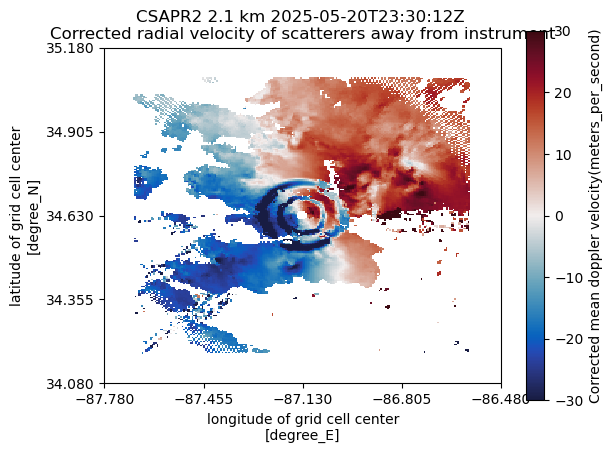

In [36]:
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('corrected_velocity',
                  level=4,
                  cmap='balance')